# Evaluation of the CRF Model

In [13]:
# Imports
import ast
import pickle

import spacy
import pandas as pd
import eli5
from sklearn_crfsuite import metrics
from tqdm import tqdm

from model.crf_utils import text2features, Custom_CRF
from model.evaluation_utils import visualize_transitions, print_annotated_text, crf_roc_curve, crf_log_loss, print_annotated_text_latex
from model.evaluation.majority_baseline import majorityBaseline
from model.evaluation.majority_baseline_proba import majorityProbaBaseline
from model.evaluation.number_baseline import numberBaseline
from model.evaluation.ne_baseline import neBaseline

In [14]:
# Parameter
POS_FEATURES = True
ENT_TYPE_FEATURES = True
LEMMA_FEATURES = True
IS_FEATURES = True
POSITION_FEATURES = True
BIAS = True
BEGIN = -1
END = 1

In [15]:
#Load the CRF Model
filename = "model/trainedModels/crf_fully_trained.obj"
with open(filename, 'rb') as f:
    model = pickle.load(f)
    
#Load Baseline
#model = numberBaseline()

In [16]:
# Load the Test data
TEST_FILENAME = "data/preprocessedData/dev_IO_with_plausible_answers.csv"
df_askable_paragraph_test = pd.read_csv(TEST_FILENAME)
df_askable_paragraph_test["askable_tokens"] = [ast.literal_eval(t) for t in df_askable_paragraph_test["askable_tokens"]]

TRAIN_FILENAME = "data/preprocessedData/train_IO_with_plausible_answers.csv"
df_askable_paragraph_train = pd.read_csv(TRAIN_FILENAME)
df_askable_paragraph_train["askable_tokens"] = [ast.literal_eval(t) for t in df_askable_paragraph_train["askable_tokens"]]
df_askable_paragraph_train_sample = df_askable_paragraph_train.sample(n=1000, random_state=1)

In [17]:
nlp = spacy.load('en')

In [18]:
# calculate the features for the Test data
X_test = [text2features(nlp(s), pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END) for s in tqdm(df_askable_paragraph_test["paragraph_context"])]
y_test = list(df_askable_paragraph_test["askable_tokens"])

100%|██████████| 1204/1204 [01:29<00:00, 17.13it/s]


In [ ]:
# calculate the features for the Train data
X_train_sample = [text2features(nlp(s), pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END) for s in tqdm(df_askable_paragraph_train_sample["paragraph_context"])]
y_train_sample = list(df_askable_paragraph_train_sample["askable_tokens"])
model.fit(X_train_sample, y_train_sample)

In [19]:
# Predict y for Test data
y_pred_test = model.predict(X_test)
y_pred_test_marginals = model.predict_proba(X_test)

In [20]:
# Evaluate Standard Evaluation Metricies
print(metrics.flat_classification_report(
    y_test, y_pred_test, digits=5
))

             precision    recall  f1-score   support

          I    0.53417   0.00843   0.01661     35214
          O    0.80189   0.99817   0.88933    141594

avg / total    0.74857   0.80105   0.71551    176808



In [21]:
# Print one example output
paragraph = nlp("A Japan-exclusive manga series based on Twilight Princess, penned and illustrated by Akira Himekawa, was first released on February 8, 2016. The series is available solely via publisher Shogakukan's MangaOne mobile application. While the manga adaptation began almost ten years after the initial release of the game on which it is based, it launched only a month before the release of the high-definition remake.")
y_true = ['O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

tokens =[token.text for token in paragraph]
y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))
print_annotated_text(tokens, y_pred, y_trues=y_true)

In [23]:
# Print 100 randomly sampled text
from IPython.display import Latex
for index, row in df_askable_paragraph_test.iterrows(): #.sample(n=100, random_state=1)
    if nlp(row["paragraph_context"])[:3].text == "The Norman dynasty":
        paragraph = nlp(row["paragraph_context"])
        y_true = row["askable_tokens"]
        tokens =[token.text for token in paragraph]
        y_pred = model.predict_marginals_single(text2features(paragraph, pos_features=POS_FEATURES, ent_type_features=ENT_TYPE_FEATURES, lemma_features=LEMMA_FEATURES, is_features=IS_FEATURES, position_features=POSITION_FEATURES, bias=BIAS, begin=BEGIN, end=END))

        print_annotated_text(tokens, y_pred, y_trues=y_true)
        Latex(print_annotated_text_latex(tokens, y_pred, y_trues=y_true))

In [11]:
# Calculate the log loss
print("Log Loss on the test data: " + str(crf_log_loss(y_test, y_pred_test_marginals)))

Log Loss on the test data: 6.953739781738583


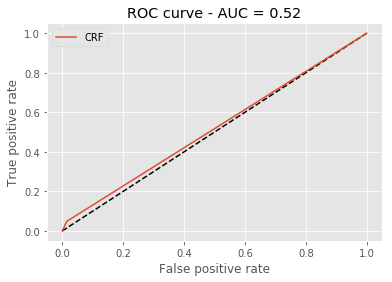

In [12]:
# Print ROC Curve
crf_roc_curve(y_test, y_pred_test_marginals)

## CRF Specific

In [ ]:
# Print list of top weighted features
eli5.show_weights(model, top=25)

In [ ]:
# Show trasition weights
visualize_transitions(crf)

In [10]:
a = {"A":1, "B":2}

In [26]:
b = set(a.keys())

In [28]:
b.discard("A")

In [29]:
b

{'B'}